In [1]:
import math
import tqdm
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 

In [2]:
import os
from scipy.io import loadmat
from math import floor
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

data_raw = pd.read_csv('./expData_more_20240320.csv')
data_index = data_raw.columns[52:52+52].append(data_raw.columns[[104, 106, 105]])
X = torch.Tensor(np.array(data_raw[data_index]))

af = data_raw['af']

# Split 
af_unique = np.unique(af)
train_afu, test_afu = train_test_split(af_unique, test_size = .1, random_state = 1) # 0

# Manual override
test_afu = ['NACA64A010', 'NACA64A406']
# val_afu = ['SC1095']
train_afu = np.delete(af_unique, np.argwhere(af_unique==test_afu[0]))
train_afu = np.delete(train_afu, np.argwhere(train_afu==test_afu[1]))
# train_afu = np.delete(train_afu, np.argwhere(train_afu==val_afu[0]))


train_ind = data_raw['af'].isin(train_afu).values
test_ind = data_raw['af'].isin(test_afu).values
# val_ind = data_raw['af'].isin(val_afu).values
# X = data
# X = X - X.min(0)[0]
# X = 2 * (X / X.max(0)[0]) - 1

y = torch.Tensor(data_raw['Cp'])*100
y_mean = torch.mean(y)
y_std = torch.std(y)
# y = (y-torch.mean(y))/torch.std(y)
noise = (torch.Tensor(data_raw['noise'])*100)**2*10 # 
train_x = X[train_ind]
test_x = X[test_ind]
train_y = y[train_ind]
test_y = y[test_ind]
train_af = data_raw['af'][train_ind]
test_af = data_raw['af'][test_ind]
train_noise = noise[train_ind]
test_noise = noise[test_ind]

# Validation data
# val_x = X[val_ind]
# val_y = y[val_ind]
# val_noise = noise[val_ind] 

n_devices = torch.cuda.device_count()
output_device = torch.device('cuda:0')
# del X, data_raw

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.to(output_device), train_y.to(output_device), test_x.to(output_device), test_y.to(output_device)
    # val_x, val_y = val_x.contiguous().to(output_device), val_y.contiguous().to(output_device)

print(test_afu) 

['NACA64A010', 'NACA64A406']


In [15]:
data_dim = train_x.size(-1)
nn_dims = [1000, 500, 50, 8] # 5[1000, 500, 50, 6]

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, nn_dims[0]))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(nn_dims[0], nn_dims[1]))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(nn_dims[1], nn_dims[2]))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(nn_dims[2], nn_dims[3]))
        if len(nn_dims) > 4:
            self.add_module('relu4', torch.nn.ReLU())
            self.add_module('linear5', torch.nn.Linear(nn_dims[3], nn_dims[4]))
feature_extractor = LargeFeatureExtractor()

In [16]:

print(n_devices)
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            
            grid_size = 10#gpytorch.utils.grid.choose_grid_size(train_x)
            # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=nn_dims[-1])),
            #     num_dims=nn_dims[-1], grid_size=grid_size
            # )
            
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.keops.MaternKernel(nu=0.5, ard_num_dims=nn_dims[-1]))

            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1.0, 1.0)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(train_noise) 
model = GPRegressionModel(train_x, train_y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    
best_loss = float('inf')
best_model_state_dict = None
counter = 0
if 'history_GP' in locals():
    del history_GP

1


train

In [26]:
training_iterations = 500*2
import tqdm.notebook as tn 
torch.cuda.empty_cache()
# Find optimal model hyperparameters

model.train()
likelihood.train()
if 'history_GP' in locals():
    history_GP = np.hstack((history_GP, np.zeros((nn_dims[-1], training_iterations))))
else: 
    history_GP = np.zeros((nn_dims[-1], training_iterations))
    
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=1e-4) # 
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

print(best_loss)
def train(): 
    global best_loss, best_model_state_dict, counter
    iterator = tn.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        
        # Get output from model
        output = model(train_x)
        
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        
        model.train()
        # Check if current loss is the best so far <- not sure if working
        
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        
        history_GP[:, counter] = optimizer.param_groups[1]['params'][1][0].cpu().detach().numpy() # place holder 
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state_dict = model.state_dict()
            
        counter += 1 
        
%time train()

if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    
model.eval()
likelihood.eval()

7.950345039367676


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 3min 23s, sys: 741 ms, total: 3min 23s
Wall time: 3min 24s


FixedNoiseGaussianLikelihood(
  (noise_covar): FixedGaussianNoise()
)

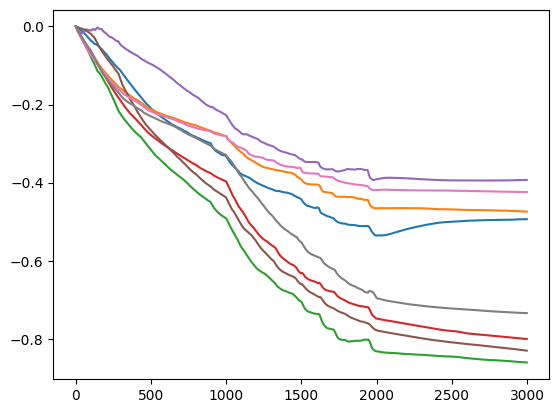

In [27]:
# plt.plot(history_GP.reshape((-1, nn_dims[-1])))


for i in range(0, nn_dims[-1]):
    plt.plot(history_GP[i, :])

Evaluate and check MAE

In [29]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds_test = model(test_x)
    preds_train = model(train_x)

print('Train MAE: {}'.format(torch.mean(torch.abs(preds_train.mean - train_y))))
print('Test MAE: {}'.format(torch.mean(torch.abs(preds_test.mean - test_y))))

Train MAE: 2.85669207572937
Test MAE: 16.311508178710938


Text(0, 0.5, '$C_p$')

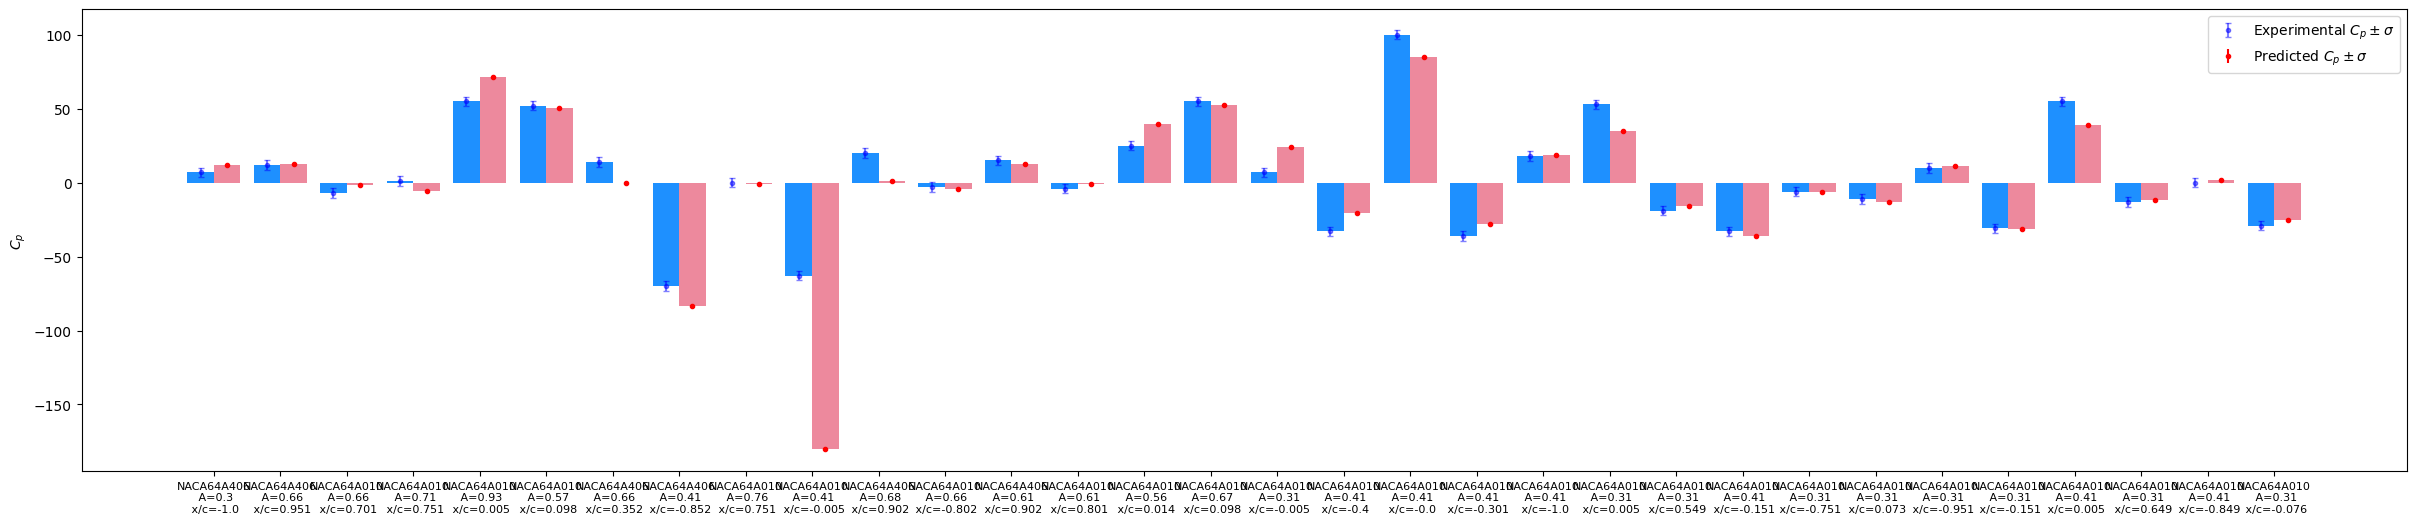

In [30]:

# plt.plot(preds_train.mean.cpu())
# plt.plot(train_y.cpu())
plt.figure(figsize=(30,6))
preds_std = np.sqrt(np.diag(preds_test.covariance_matrix.cpu()))

dispNum = 32
import random
random.seed(30)
# 2 
# test_af[dispInds] + 

# dispInds = random.sample(range(1, test_x.cpu().shape[0]), dispNum)
dispInds1 = random.sample(range(0, test_x.cpu().shape[0]), int(dispNum/2))
dispInds2 = random.sample(range(0, 65), int(dispNum/2))
dispInds = np.concatenate((dispInds1, dispInds2))
# caseStr = 

afStr = np.array(test_af)[dispInds].flatten() # 
locStr = np.array(np.round(test_x.cpu(),3))[dispInds, -1].astype(str).flatten()
AStr = np.array(test_x.cpu())[dispInds, -2].astype(str).flatten()


finalStr = afStr + '\n A=' + AStr + '\n x/c=' + locStr


plt.errorbar(np.arange(len(test_y[dispInds]))-0.2, test_y.cpu()[dispInds], yerr = np.sqrt(test_noise[dispInds]), capsize=2, label='Experimental $C_p \pm \sigma$', fmt='.', color = 'b', alpha =0.5)
plt.bar(np.arange(len(test_y[dispInds]))-0.2, test_y.cpu()[dispInds], color='dodgerblue', width = 0.4)
plt.errorbar(np.arange(len(test_y[dispInds]))+0.2, preds_test.mean.cpu()[dispInds],  yerr = preds_std[dispInds], label='Predicted $C_p \pm \sigma$', fmt='r.')
plt.bar(np.arange(len(test_y[dispInds]))+0.2, preds_test.mean.cpu()[dispInds], color='crimson', width = 0.4, alpha =0.5, capsize=2)
plt.legend()
plt.xticks(np.arange(0, dispNum), finalStr, fontsize=8);
plt.ylabel('$C_p$')

['NACA64A010', 'NACA64A406']


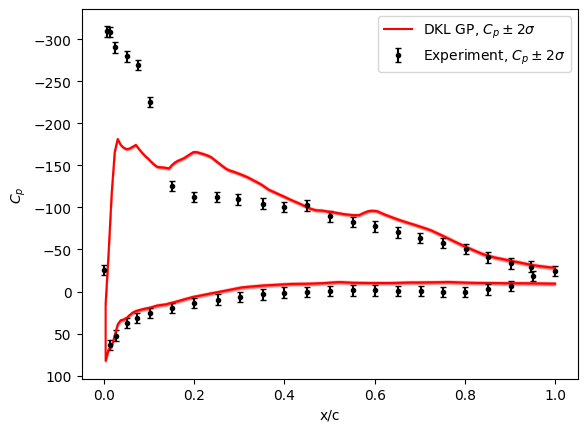

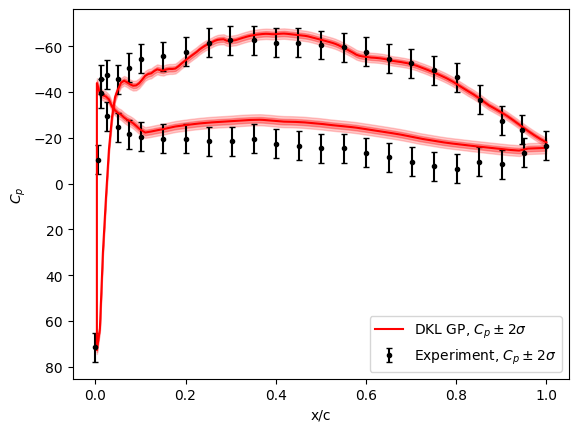

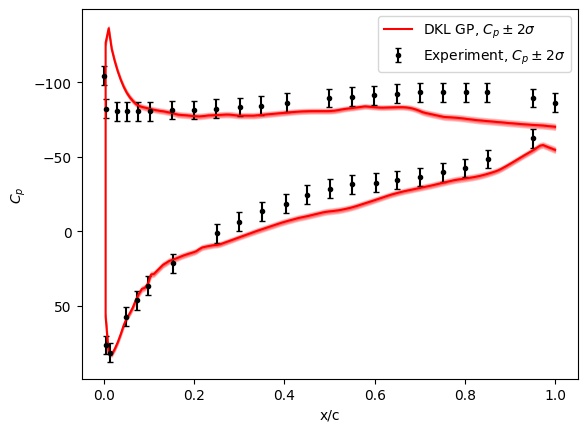

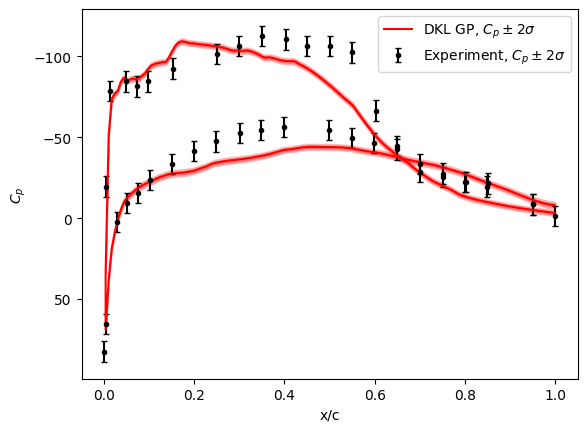

In [31]:
plotter = [(6.0, test_afu[1], 0.6), (0.0, test_afu[1], 0.31), (16.2, test_afu[0], 0.52), (-1.8, test_afu[0], 0.81)]#, (4.0, test_afu[1])]
print(test_afu)


for i in np.arange(0, len(plotter)):#[6,7,8,9]:
    plt.figure()
    targetA = plotter[i][0]
    targetAF = plotter[i][1]
    targetM = plotter[i][2]
    
    tempA = torch.where(test_x[:, -3].cpu() == targetA)[0].numpy()
    tempAF = np.where(test_af.values == targetAF)
    tempM = torch.where(test_x[:, -2].cpu() == targetM)[0].numpy()

    ind_search = np.intersect1d(np.intersect1d(tempA, tempAF), tempM)

    sample_airfoil_temp = np.tile(test_x[ind_search[0],:-2].cpu(), (300,1))
    desired_xc = np.linspace(-1, 1, 300).reshape((300,1))
    desired_M = np.ones((300,1))*targetM
    sample_airfoil = torch.Tensor(np.hstack((sample_airfoil_temp, desired_M, desired_xc))).cuda()

    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        sample_airfoil_pred = model(sample_airfoil)
    
    sample_airfoil_std = np.sqrt(np.diag(sample_airfoil_pred.covariance_matrix.cpu()))
    # newDist = torch.distributions.multivariate_normal.MultivariateNormal(sample_airfoil_pred.mean.cpu(), sample_airfoil_pred.covariance_matrix.cpu() + torch.eye(sample_airfoil_pred.covariance_matrix.cpu().shape[0])*1e-5)
    
    plt.errorbar(np.abs(test_x[ind_search, -1].cpu()), test_y[ind_search].cpu() + torch.mean(y), yerr=2*np.sqrt(noise[ind_search]), fmt='k.', capsize=2, label='Experiment, $C_p \pm 2\sigma$')
    
    # plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.sample(sample_shape=1) + torch.mean(y))
    plt.fill_between(-desired_xc[:150].flatten(), sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) + sample_airfoil_std[:150], sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) - sample_airfoil_std[:150], color = 'r', alpha = 0.3)
    plt.fill_between(desired_xc[150:].flatten(), sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) + sample_airfoil_std[150:], sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) - sample_airfoil_std[150:], color = 'r', alpha = 0.3)
    plt.fill_between(-desired_xc[:150].flatten(), sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) + 2*sample_airfoil_std[:150], sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) - 2*sample_airfoil_std[:150], color = 'r', alpha = 0.2)
    plt.fill_between(desired_xc[150:].flatten(), sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) + 2*sample_airfoil_std[150:], sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) - 2*sample_airfoil_std[150:], color = 'r', alpha = 0.2)
    # for j in np.arange(0, 5):
    #     plt.plot(np.abs(sample_airfoil[:, -1].cpu()), newDist.sample()+ torch.mean(y), alpha = 0.2, color = 'r')
    plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.mean.cpu() + torch.mean(y),'r', label='DKL GP, $C_p \pm 2\sigma$')
    plt.gca().invert_yaxis()
    plt.xlabel('x/c')
    plt.ylabel('$C_p$')
    plt.legend()
    # plt.title(targetAF +'\n' + r'$\alpha$ = ' + str(targetA) + r'$^\circ,$' + r' $M_\infty = 0.60$')
# test_x

In [ ]:
# Latent variable plotter 1 - Latent variables vs each other 
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))
for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        for jj in np.arange(0, train_afu.shape[0]):
            plot_ind = np.argwhere(train_af.values == train_afu[jj])
            ax[i,j].scatter(extracted_values[plot_ind, i], extracted_values[plot_ind, j], marker='.',s=8)
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])

In [ ]:
# Latent variable plotter 1 - Latent variables vs each other 
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))

# plt.figure()
# plt.scatter(extracted_values[:, 0], extracted_values[:, 1], c=train_y.cpu(), marker='.', s=8)

for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        ff = ax[i,j].scatter(extracted_values[:, i], extracted_values[:, j], c=train_y.cpu(), marker='.', s=8)
        
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])
        
cbar = plt.colorbar(ff)



In [ ]:
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))
for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        ax[i,j].scatter(extracted_values[:, i], extracted_values[:, j], c=preds_train.mean.cpu(), marker='.', s=8)
        
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])

Save & load

In [ ]:
torch.save(model.state_dict(), 'aaa')

In [ ]:
model.load_state_dict(torch.load('aaa'))

In [ ]:
plotter = [(10.0, train_afu[0]), (9.1, train_afu[-2])]#, (2.0, train_afu[6])]
print(train_afu)
for i in np.arange(0, len(plotter)):#[6,7,8,9]:
    plt.figure()
    targetA = plotter[i][0]

    targetAF = plotter[i][1]
    tempA = torch.where(train_x[:, -2].cpu() == targetA)[0].numpy()
    tempAF = np.where(train_af.values == targetAF)
    ind_search = np.intersect1d(tempA, tempAF)

    sample_airfoil_temp = np.tile(train_x[ind_search[0],:-1].cpu(), (300,1))
    desired_xc = np.linspace(-1, 1, 300).reshape((300,1))
    sample_airfoil = torch.Tensor(np.hstack((sample_airfoil_temp, desired_xc))).cuda()

    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        sample_airfoil_pred = model(sample_airfoil)
    
    sample_airfoil_std = np.sqrt(np.diag(sample_airfoil_pred.covariance_matrix.cpu()))
    newDist = torch.distributions.multivariate_normal.MultivariateNormal(sample_airfoil_pred.mean.cpu(), sample_airfoil_pred.covariance_matrix.cpu() + torch.eye(sample_airfoil_pred.covariance_matrix.cpu().shape[0])*1e-5)
    
    plt.errorbar(np.abs(train_x[ind_search, -1].cpu()), train_y[ind_search].cpu() + torch.mean(y), yerr=2*np.sqrt(train_noise[ind_search]), fmt='k.', capsize=2, label='Experiment, $C_p \pm 2\sigma$')
    
    # plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.sample(sample_shape=1) + torch.mean(y))
    plt.fill_between(-desired_xc[:150].flatten(), sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) + sample_airfoil_std[:150], sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) - sample_airfoil_std[:150], color = 'r', alpha = 0.3)
    plt.fill_between(desired_xc[150:].flatten(), sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) + sample_airfoil_std[150:], sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) - sample_airfoil_std[150:], color = 'r', alpha = 0.3)
    plt.fill_between(-desired_xc[:150].flatten(), sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) + 2*sample_airfoil_std[:150], sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) - 2*sample_airfoil_std[:150], color = 'r', alpha = 0.2)
    plt.fill_between(desired_xc[150:].flatten(), sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) + 2*sample_airfoil_std[150:], sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) - 2*sample_airfoil_std[150:], color = 'r', alpha = 0.2)
    # for j in np.arange(0, 5):
    #     plt.plot(np.abs(sample_airfoil[:, -1].cpu()), newDist.sample()+ torch.mean(y), alpha = 0.2, color = 'r')
    plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.mean.cpu() + torch.mean(y),'r', label='DKL GP, $C_p \pm 2\sigma$')
    plt.gca().invert_yaxis()
    plt.xlabel('x/c')
    plt.ylabel('$C_p$')
    plt.legend()
    plt.title(targetAF +'\n' + r'$\alpha$ = ' + str(targetA) + r'$^\circ,$' + r' $M_\infty = 0.60$')

Quick Cl Cd calculation

In [ ]:

manual_Cl = -np.trapz(y=(sample_airfoil_pred.mean.cpu()+torch.mean(y))[:150], x=desired_xc.flatten()[:150]) + np.trapz(y=(sample_airfoil_pred.mean.cpu()+torch.mean(y))[150:], x=desired_xc.flatten()[150:])
print(np.trapz(y=(sample_airfoil_pred.mean.cpu())[:150]+torch.mean(y), x=desired_xc.flatten()[:150]) + np.trapz(y=(sample_airfoil_pred.mean.cpu())[150:]+torch.mean(y), x=desired_xc.flatten()[150:]))
# torch.linalg.inv(temp_Kxx) @ train_y.cpu()
# print(model.covar_module(train_x))

print(sample_airfoil[0,-2])
def lazy_Cl_Cd_Cm(x, cp, a):
    N = np.trapz(cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz(cp[150:], x=x.flatten()[150:])
    Cl = N * np.cos(np.deg2rad(a))
    Cd = N * np.sin(np.deg2rad(a))
    Cm = np.trapz((np.abs(x.flatten())[:150]-0.25) * cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz((x.flatten()[150:]-0.25) * cp[150:], x=x.flatten()[150:]) # <- double check
    return Cl, Cd, Cm  

def GP_Cl_Cd_Cm(model, train_x, test_data):
    model = model.cpu()
    train_x = train_x.cpu()
    test_data = test_data.cpu()
    
    projected_xtrain = model.feature_extractor(train_x)
    projected_xtrain = model.scale_to_bounds(projected_xtrain)
    projected_xtest = model.feature_extractor(test_data)
    projected_xtest = model.scale_to_bounds(projected_xtest)
    jitter = 1e-5 * torch.eye(train_x.shape[0])
    Kxx = (model.covar_module(projected_xtrain).evaluate().cpu() + train_noise * torch.eye(train_x.shape[0]) + jitter).detach().numpy()
    Kxs = model.covar_module(projected_xtrain, projected_xtest).evaluate().cpu().detach().numpy()

    KxsT = Kxs.T
    temp_ind = np.argwhere(np.array(desired_xc).flatten() < 0.0)
    KxsT[temp_ind, :] *= -1
    i_Kxs = np.trapz(y=KxsT, x=np.array(desired_xc).flatten(), axis=0).reshape((-1,1)).T
    N = i_Kxs @ np.linalg.inv(Kxx) @ train_y.cpu().numpy()
    a = test_data[0, -2].numpy()
    print(N)
    Cl = N * np.cos(np.deg2rad(a))
    Cd = N * np.sin(np.deg2rad(a))
    # Cm = np.trapz((np.abs(x.flatten())[:150]-0.25) * cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz((x.flatten()[150:]-0.25) * cp[150:], x=x.flatten()[150:]) # <- double check
    return Cl, Cd  

lazy_Cl_Cd_Cm(desired_xc.flatten(), (sample_airfoil_pred.mean.cpu()+torch.mean(y)).detach().numpy(), a = 9.1)
GP_Cl_Cd_Cm(model, train_x, sample_airfoil)

In [ ]:
plt.plot(np.abs(desired_xc.flatten()), asdf + torch.mean(y).numpy())